In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/ECG_classification/archive/mitbih_train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/ECG_classification/archive/mitbih_test.csv')

data_train.head()
data_test.head()

class_distribution1 = data_train.iloc[:, -1].value_counts()
class_distribution2 = data_test.iloc[:, -1].value_counts()
print(class_distribution1)
print(class_distribution2)


0.000000000000000000e+00.88
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64
0.000000000000000000e+00.65
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [ ]:
data = data_train[data_train.iloc[:, :-1].sum(axis=1) != 0]
data_test = data_test[data_test.iloc[:, :-1].sum(axis=1) != 0]

X_train = data.iloc[:, :-1].values
y_train = data.iloc[:, -1].values

X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print('Train:')
print(X_train_scaled.shape, y_train.shape)
print('Test:')
print(X_test_scaled.shape, y_test.shape)


Train:
(87553, 187, 1) (87553,)
Test:
(21891, 187, 1) (21891,)


In [ ]:
X_train, X_test, y_train, y_test = X_train_scaled, X_test_scaled, y_train, y_test

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(class_weight_dict)


{0.0: 0.2416255002069822, 1.0: 7.877013045434098, 2.0: 3.025328265376641, 3.0: 27.317628705148206, 4.0: 2.7228424817291246}


In [ ]:
def build_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    model.add(layers.LSTM(64, return_sequences=False))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

model = build_model(input_shape, num_classes)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 185, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 92, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 90, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 43, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 19, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 9, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,101 (828.52 KB)

 Trainable params: 212,101 (828.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping])


Epoch 1/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.5468 - loss: 0.8749 - val_accuracy: 0.8269 - val_loss: 0.5384
Epoch 2/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.8064 - loss: 0.4364 - val_accuracy: 0.8981 - val_loss: 0.3416
Epoch 3/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8539 - loss: 0.3184 - val_accuracy: 0.8686 - val_loss: 0.3329
Epoch 4/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8786 - loss: 0.2580 - val_accuracy: 0.8765 - val_loss: 0.3200
Epoch 5/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8941 - loss: 0.2210 - val_accuracy: 0.9118 - val_loss: 0.2699
Epoch 6/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9067 - loss: 0.1952 - val_accuracy: 0.9145 - val_loss: 0.2534
Epoch 7/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9145 - loss: 0.1726 - val_accuracy: 0.8847 - val_loss: 0.3182
Epoch 8/50
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9181 - loss: 0

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9757 - loss: 0.0777
Test Accuracy: 96.83%, Test Loss: 0.11


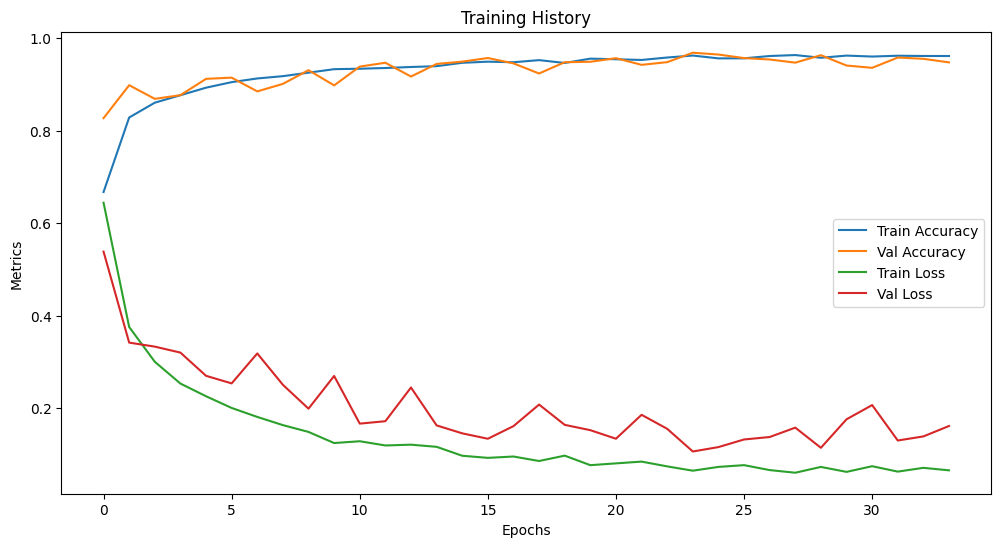

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training History")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()


In [ ]:
y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))

model.save("/content/drive/MyDrive/ECG_classification/mitbih_Conv_LSTM_model.h5")


685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18117
         1.0       0.63      0.85      0.72       556
         2.0       0.93      0.92      0.93      1448
         3.0       0.53      0.90      0.66       162
         4.0       0.98      0.98      0.98      1608

    accuracy                           0.97     21891
   macro avg       0.81      0.92      0.85     21891
weighted avg       0.97      0.97      0.97     21891

